In [1]:
import qpas
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import pandas as pd
import h5py
from scipy.optimize import least_squares
import matplotlib
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.patches as patches
import scipy.optimize as optimization
from skimage.transform import resize

### SET DATA DIR ###
DATA_PATH = "/SET_DATA_PATH/"
### DEFINE WAVELENGTHS ###
WL = np.asarray([760,780,800,820,840,
                 860,880,900,980])
WL_id = np.asarray([4,5,6,7,8,9,10,11,15])
SELECTED_WL = [0,1,2,3,4,5,6,7,9]

#TAG = "_no_water"  #980 15 9
#TAG = "_no_water_no_920"  #920 15 9
TAG = "_no_920" #920 12 8
#TAG = "_all"

ILL = np.asarray([0,1,2,3])

### (1) SET META DATA ###
NO_SEQUENCES_IN_FILE = 10
NO_FILES = 29

### load laser pulse energy spectrum
df_opo = pd.read_csv(DATA_PATH+"opo_pulse_energy_spectrum_3mm_fiber.csv", header=0)
corr_opo = np.asarray(df_opo['mean E after 3mm fiber/mJ'])
corr_opo_WL = np.asarray(df_opo['nm'])

# choose correct $WL
corr_opo = corr_opo[np.isin(corr_opo_WL, WL)]

wl_in_silico_full = np.arange(680,981,20)

### load in silico data
X_train = np.load(DATA_PATH+'MI-LSD_sO2_skin_TRAIN_array_spectra.npy')
X_test = np.load(DATA_PATH+'MI-LSD_sO2_skin_TEST_array_spectra.npy')
y_train = np.load(DATA_PATH+'MI-LSD_sO2_skin_TRAIN_array_label_sO2.npy')
y_test = np.load(DATA_PATH+'MI-LSD_sO2_skin_TEST_array_label_sO2.npy')

### choose correct $WL
X_train = X_train[:,np.isin(wl_in_silico_full, WL),:]
X_test = X_test[:,np.isin(wl_in_silico_full, WL),:]

X_lsd_train = np.mean(X_train, axis=0)
X_lsd_test = np.mean(X_test, axis=0)
X_lsd_train = X_lsd_train / np.sum(X_lsd_train, axis=0)
X_lsd_test = X_lsd_test / np.sum(X_lsd_test, axis=0)

### shape in silico data for MI LSD normalization
X_mi_lsd_train = np.zeros([len(WL)*len(ILL), X_train.shape[2]])
X_mi_lsd_test = np.zeros([len(WL)*len(ILL), X_test.shape[2]])

for i in range(X_train.shape[2]):
    for j in range(len(ILL)):
        X_mi_lsd_train[j*X_train.shape[1]:(j+1)*X_train.shape[1], 
                       i] = X_train[j,:,i] / np.sum(X_train[j,:,i], axis=0)
        
for i in range(X_test.shape[2]):
    for j in range(len(ILL)):
        X_mi_lsd_test[j*X_test.shape[1]:(j+1)*X_test.shape[1], 
                      i] = X_test[j,:,i] / np.sum(X_test[j,:,i], axis=0)

In [2]:
import time

In [5]:
# estimate classically

start = time.time()
y_lu_est, _ = qpas.svd_pi_lu_oxy(input_data=X_lsd_test, wavelength_axis=0, 
                                 hemoglobin_df_path=DATA_PATH, wavelenghs=WL)
end = time.time()
print("lu for size ", y_lu_est.size, ":", end - start)

### train gradient boosting machines on in silico TRAINing data set

reg_lsd = LGBMRegressor(objective='regression_l1',
                        n_estimators=300, num_leaves=200, seed=1)
reg_mi_lsd = LGBMRegressor(objective='regression_l1',
                           n_estimators=300, num_leaves=200, seed=1)

start = time.time()
reg_lsd = reg_lsd.fit(X_lsd_train.T, y_train)
end = time.time()
print("lsd train for size ", y_train.size, ":", end - start)


start = time.time()
reg_mi_lsd = reg_mi_lsd.fit(X_mi_lsd_train.T, y_train)
end = time.time()
print("mi-lsd train for size ", y_train.size, ":", end - start)

# estimate the in silico TEST data set
start = time.time()
y_lsd_est = reg_lsd.predict(X_lsd_test.T)
end = time.time()
print("lsd test for size ", y_lsd_est.size, ":", end - start)

start = time.time()
y_mi_lsd_est = reg_mi_lsd.predict(X_mi_lsd_test.T)
end = time.time()
print("mi-lsd train for size ", y_mi_lsd_est.size, ":", end - start)


lu for size  265979 : 0.02489614486694336
lsd train for size  1050673 : 12.98528003692627
mi-lsd train for size  1050673 : 19.938295364379883
lsd test for size  265979 : 0.7120680809020996
mi-lsd train for size  265979 : 0.8333873748779297


lu Q1: 6.1; Q2: 13.1; Q3: 22.3; P90: 31.5
lsd Q1: 2.3; Q2: 5.2; Q3: 10.7; P90: 18.3
mi-lsd Q1: 1.7; Q2: 3.8; Q3: 7.4; P90: 12.6


/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


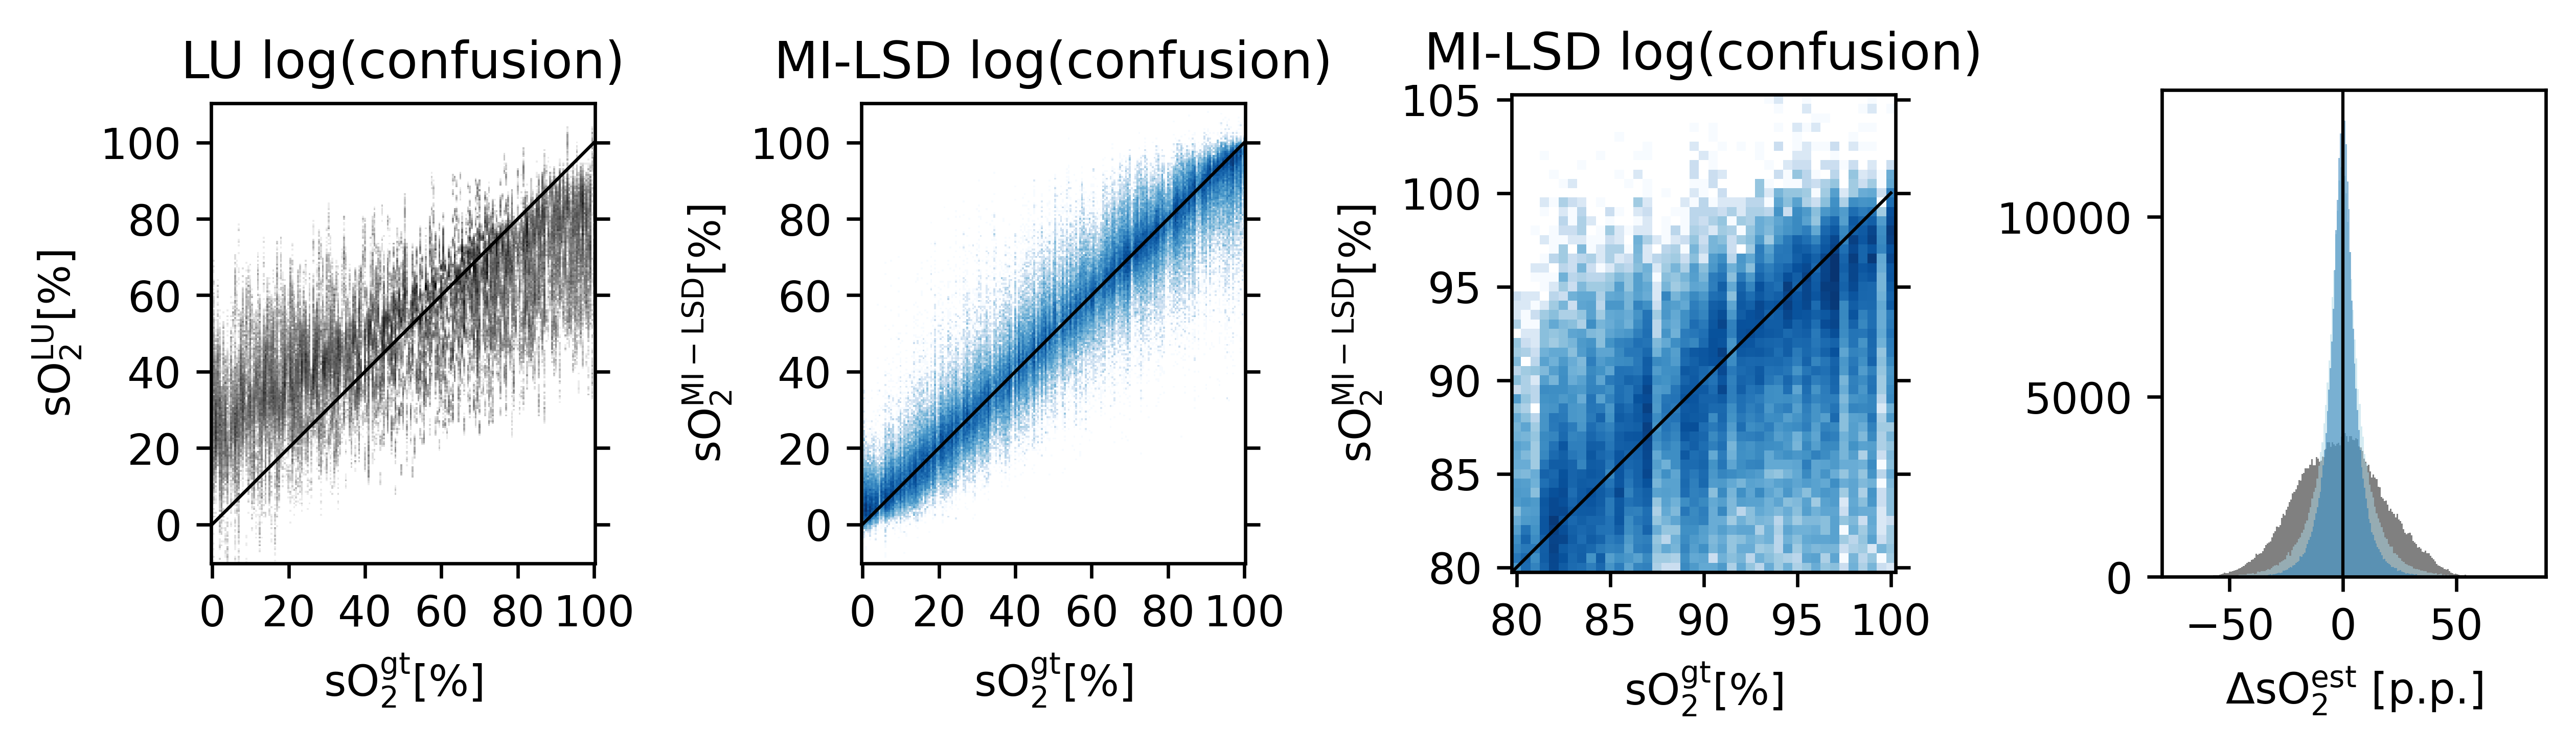

In [6]:
# in silico performance indicators
print("lu Q1: " + str(np.round(np.percentile(np.abs(y_test-y_lu_est)*100, 25),1)) 
      + "; Q2: " + str(np.round(np.median(np.abs(y_test-y_lu_est)*100),1)) 
      + "; Q3: " + str(np.round(np.percentile(np.abs(y_test-y_lu_est)*100, 75),1))
      + "; P90: " + str(np.round(np.percentile(np.abs(y_test-y_lu_est)*100, 90),1)))

print("lsd Q1: " + str(np.round(np.percentile(np.abs(y_test-y_lsd_est)*100, 25),1)) 
      + "; Q2: " + str(np.round(np.median(np.abs(y_test-y_lsd_est)*100),1)) 
      + "; Q3: " + str(np.round(np.percentile(np.abs(y_test-y_lsd_est)*100, 75),1))
      + "; P90: " + str(np.round(np.percentile(np.abs(y_test-y_lsd_est)*100, 90),1)))

print("mi-lsd Q1: " + str(np.round(np.percentile(np.abs(y_test-y_mi_lsd_est)*100, 25),1))
      + "; Q2: " + str(np.round(np.median(np.abs(y_test-y_mi_lsd_est)*100),1)) 
      + "; Q3: " + str(np.round(np.percentile(np.abs(y_test-y_mi_lsd_est)*100, 75),1))
      + "; P90: " + str(np.round(np.percentile(np.abs(y_test-y_mi_lsd_est)*100, 90),1)))

fig, ax = plt.subplots(1,4, figsize=(8.5,2.5), dpi=600)

ax[3].axvline(x=0, color="black", lw=0.75)
ax[3].hist((y_test-y_lu_est)*100, bins=200, alpha=1, label="LU", color='grey')
ax[3].hist((y_test-y_lsd_est)*100, bins=200, alpha=0.5, label="LSD", color='lightblue')
ax[3].hist((y_test-y_mi_lsd_est)*100, bins=200, alpha=0.5, label="MI-LSD", color='tab:blue')
#ax[3].legend()
ax[3].set_xlabel("$\Delta$sO$_{2}^\mathrm{est}$ [p.p.]")
#ax[3].set_title("Estimation error distribution")

xedges = np.linspace(-0.005,1.005,203)
yedges = np.linspace(-0.105,1.105,243)
H, xedges, yedges = np.histogram2d(y_test, y_mi_lsd_est, bins=(xedges, yedges))

ax[1].imshow(np.log(H.T),cmap=plt.cm.Blues)
ax[1].plot([0,200],[20,220], color='black', lw=0.75)
ax[1].set_xlim(-0.5,200.5)
ax[1].set_ylim(-0.5,240.5)
ax[1].set_xticks(np.arange(0, 202, step=40))
ax[1].set_xticklabels(np.arange(0, 101, step=20))
ax[1].set_yticks(np.arange(20, 242, step=40))
ax[1].set_yticklabels(np.arange(0, 101, step=20))
ax[1].set_title("MI-LSD log(confusion)")
ax[1].set_xlabel("sO$_{2}^\mathrm{gt} [\%]$")
ax[1].set_ylabel("sO$_{2}^\mathrm{MI-LSD} [\%]$")

ax[2].imshow(np.log(H.T),cmap=plt.cm.Blues)
ax[2].plot([0,200],[20,220], color='black', lw=0.75)
ax[2].set_xlim(159.5,200.5)
ax[2].set_ylim(179.5,230.5)
ax[2].set_xticks(np.arange(160, 201, step=10))
ax[2].set_xticklabels(np.arange(80, 101, step=5))
ax[2].set_yticks(np.arange(180, 231, step=10))
ax[2].set_yticklabels(np.arange(80, 106, step=5))
ax[2].set_title("MI-LSD log(confusion)")
ax[2].set_xlabel("sO$_{2}^\mathrm{gt} [\%]$")
ax[2].set_ylabel("sO$_{2}^\mathrm{MI-LSD} [\%]$")


xedges = np.linspace(-0.005,1.005,203)
yedges = np.linspace(-0.105,1.105,243)
H, xedges, yedges = np.histogram2d(y_test, y_lu_est, bins=(xedges, yedges))

ax[0].imshow(np.log(H.T),cmap=plt.cm.Greys)
ax[0].plot([0,200],[20,220], color='black', lw=0.75)
ax[0].set_xlim(-0.5,200.5)
ax[0].set_ylim(-0.5,240.5)
ax[0].set_xticks(np.arange(0, 201, step=40))
ax[0].set_xticklabels(np.arange(0, 101, step=20))
ax[0].set_yticks(np.arange(20, 241, step=40))
ax[0].set_yticklabels(np.arange(0, 101, step=20))
ax[0].set_title("LU log(confusion)")
ax[0].set_xlabel("sO$_{2}^\mathrm{gt} [\%]$")
ax[0].set_ylabel("sO$_{2}^\mathrm{LU} [\%]$")


ax[0].tick_params(right=True)
ax[1].tick_params(right=True)
ax[2].tick_params(right=True)

plt.tight_layout()

plt.savefig(fname=DATA_PATH+"/in_silico_results"+TAG+".png")
plt.savefig(fname=DATA_PATH+"/in_silico_results"+TAG+".svg")

plt.show()

In [8]:
# select vein and artery ROI

def choose_vessel_rois(identifier):
    """ This is just a selecting the correct manually segmented starting position of the
    radial artery(xa,ya), radial vein(xv,yv) and superficial vessel(xsv,ysv) for tracking. 
    It's not pretty but it works."""
    global xv1
    global xv2
    global yv1
    global yv2

    global xa1
    global xa2
    global ya1
    global ya2

    global xsv1
    global xsv2
    global ysv1
    global ysv2
    
    global h
    
    h = 100
        
    ## subject 1 reperfusion 
    if identifier == "reperfusion/acquisition_20210921T162325":
        xa1 = 158
        xa2 = 170
        ya1 = 46
        ya2 = 53

        xv1 = 140
        xv2 = 150
        yv1 = 44
        yv2 = 51

        xsv1 = 123
        xsv2 = 134
        ysv1 = 15
        ysv2 = 23

    ##BASELINES
    
    ## subject 1
    if identifier == "baselines/acquisition_20210816T162159":
        xv1 = 90
        xv2 = 102
        yv1 = 36
        yv2 = 43

        xa1 = 110
        xa2 = 124
        ya1 = 26
        ya2 = 42

        xsv1 = 155
        xsv2 = 170
        ysv1 = 16
        ysv2 = 25
        
        h = 100

    ## subject 2
    if identifier == "baselines/acquisition_20210816T154828":
        xv1 = 130
        xv2 = 145
        yv1 = 31
        yv2 = 37

        xa1 = 115
        xa2 = 129
        ya1 = 26
        ya2 = 42

        xsv1 = 177
        xsv2 = 190
        ysv1 = 16
        ysv2 = 25

        h = 100
        
    ## subject 3
    if identifier == "baselines/acquisition_20210907T114923":
        xv1 = 150
        xv2 = 165
        yv1 = 18
        yv2 = 27

        xa1 = 135
        xa2 = 145
        ya1 = 18
        ya2 = 27

        xsv1 = 198
        xsv2 = 205
        ysv1 = 19
        ysv2 = 26
        
        h = 100

    ## subject 4
    if identifier == "baselines/acquisition_20210907T132623":
        xv1 = 95
        xv2 = 110
        yv1 = 25
        yv2 = 36

        xa1 = 113
        xa2 = 126
        ya1 = 21
        ya2 = 32

        xsv1 = 40
        xsv2 = 52
        ysv1 = 12
        ysv2 = 23

    ## subject 5
    if identifier == "baselines/acquisition_20210907T133613":
        xv1 = 149
        xv2 = 159
        yv1 = 18
        yv2 = 28

        xa1 = 135
        xa2 = 145
        ya1 = 20
        ya2 = 30

        xsv1 = 99
        xsv2 = 112
        ysv1 = 13
        ysv2 = 20
        
        h = 200

start baselines/acquisition_20210816T162159
LU in vivo for size  7577600 : 0.6906986236572266 s
0 / 296
20 / 296
40 / 296
60 / 296
80 / 296
100 / 296
120 / 296
140 / 296
160 / 296
180 / 296
200 / 296
220 / 296
240 / 296
260 / 296
280 / 296
LSD+MI-LSD with corr and all in vivo for size  7577600 : 90.84357786178589 s


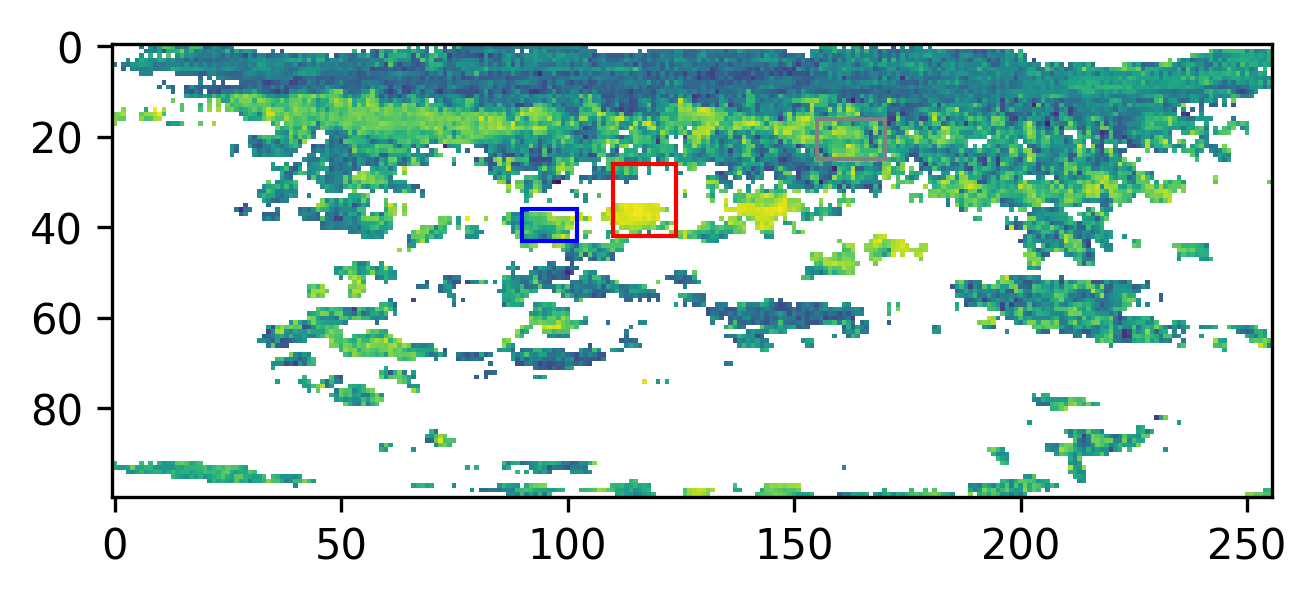

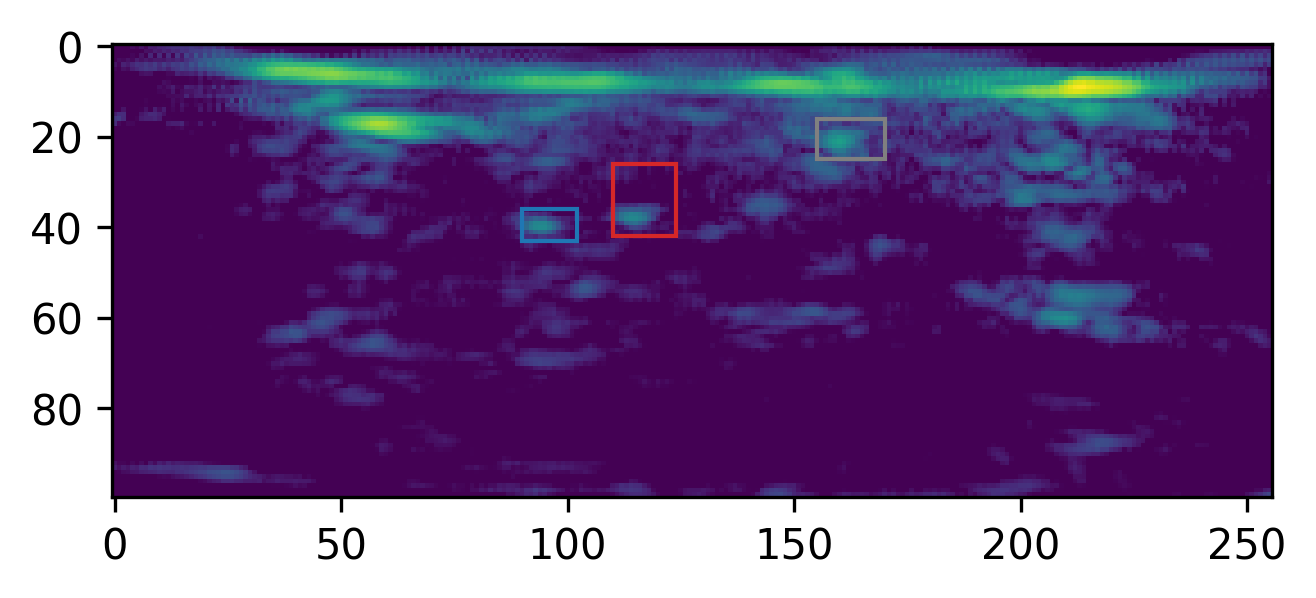

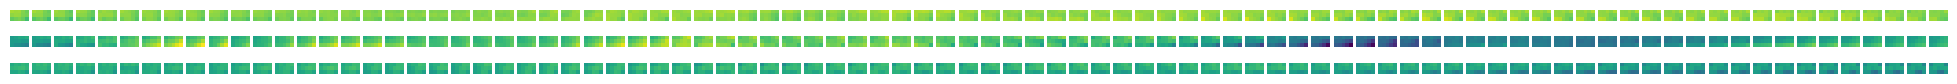

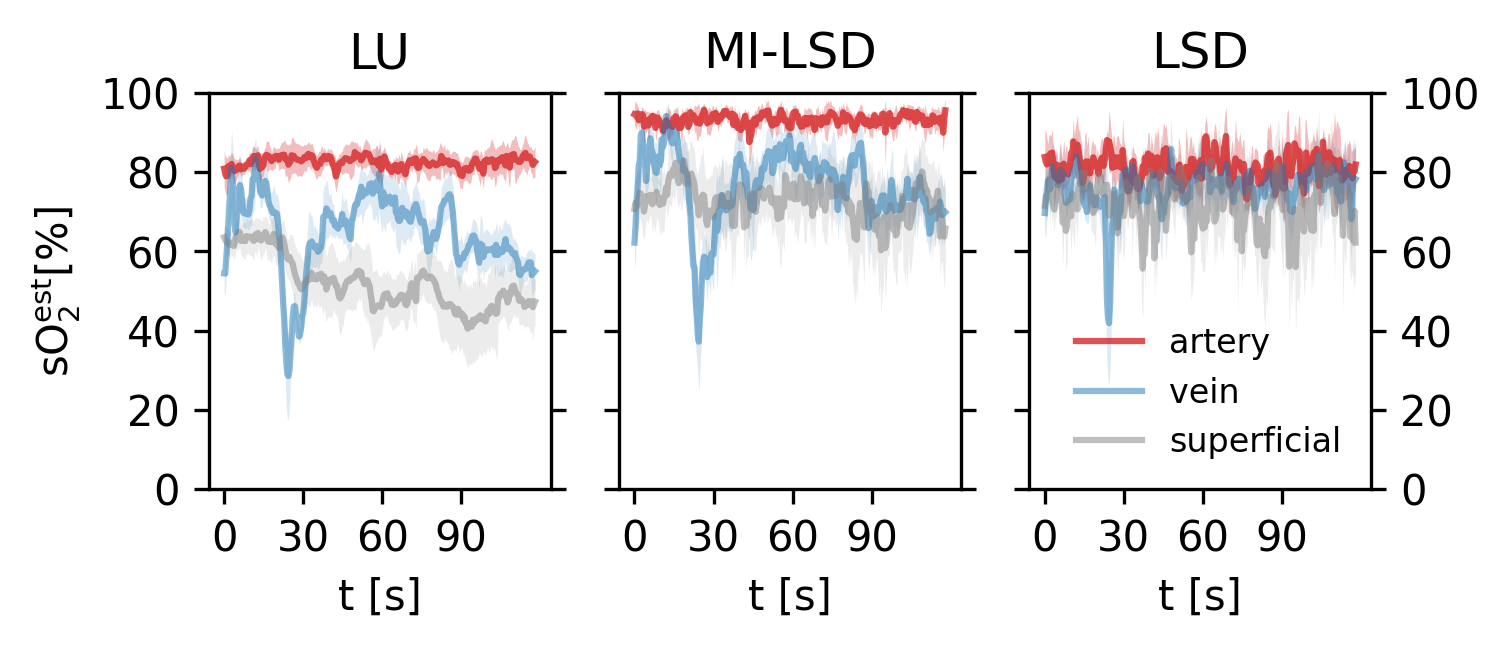

radial artery: LU 82±4
radial artery: MI-LSD 93±3
radial artery: LSD 81±7
radial vein: LU 65±11
radial vein: MI-LSD 76±12
radial vein: LSD 76±8
superficial vessel: LU 52±10
superficial vessel: MI-LSD 73±10
superficial vessel: LSD 72±11


In [9]:
### IN VIVO ###
identifiers = [
    "baselines/acquisition_20210816T162159",
    "baselines/acquisition_20210816T154828",
    "baselines/acquisition_20210907T114923",
    "baselines/acquisition_20210907T132623",
    "baselines/acquisition_20210907T133613",
    "reperfusion/acquisition_20210921T162325"]

for IDENT in identifiers:

    print("start", IDENT)
    NO_FILES = 30
    ## some recordings may contain a frame drop in one of the 30 files
    ## this file was then removed

    IDENTIFIER = IDENT
    IN_VIVO_ACQ_FOLDER = DATA_PATH + IDENTIFIER

    choose_vessel_rois(IDENTIFIER)

    # load
    pa = np.zeros([256,100,len(WL),len(ILL),NO_SEQUENCES_IN_FILE*NO_FILES])
    for i_f in range(NO_FILES):
        with h5py.File(IN_VIVO_ACQ_FOLDER+"/bmode_image_"+str(i_f)+"_PA_.h5", 'r') as f:
            pa_ = np.asarray(f['bmode_image_PA'])
            f.close
        pa[:,:,:,:,i_f*NO_SEQUENCES_IN_FILE:(i_f+1)*NO_SEQUENCES_IN_FILE] = np.swapaxes(np.swapaxes(pa_[:,68:168,:,:,:],2,4),2,3)[:,:,SELECTED_WL,:,:]

    # take rolling average
    RA_OVER = 5 # RA over 2 sec

    pa_ra = np.zeros([256,100,len(WL),len(ILL),NO_SEQUENCES_IN_FILE*NO_FILES-RA_OVER+1])
    for i_ in range(NO_SEQUENCES_IN_FILE*NO_FILES-RA_OVER+1):
        pa_ra[:,:,:,:,i_] = np.mean(pa[:,:,:,:,i_:i_+RA_OVER], axis=4)

    # correct for laser pulse energy spectrum
    pa_corr_for_lsd = np.zeros([256,100,len(WL),NO_SEQUENCES_IN_FILE*NO_FILES-RA_OVER+1])
    pa_corr_for_mi_lsd = np.zeros_like(pa_ra)
    for i_x in range(pa_ra.shape[0]):
        for i_y in range(pa_ra.shape[1]):
            for i_seq in range(pa_ra.shape[4]):
                for i_ill in range(pa_ra.shape[3]):
                    pa_corr_for_lsd[i_x, i_y, :, i_seq] += pa_ra[i_x, i_y, :, i_ill, i_seq]/corr_opo[:]
                    pa_corr_for_mi_lsd[i_x, i_y, :, i_ill, i_seq] = pa_ra[i_x, i_y, :, i_ill, i_seq]/corr_opo[:]


    # estimate oxygenation
    start = time.time()
    oxy_est_LU, total_hemoglobin_LU = qpas.svd_pi_lu_oxy(input_data=pa_corr_for_lsd, wavelength_axis=2, 
                                                         hemoglobin_df_path=DATA_PATH, wavelenghs=WL)
    end = time.time()
    print("LU in vivo for size ", oxy_est_LU.size, ":", end - start, "s")
    oxy_est_LSD = np.zeros_like(pa_corr_for_lsd[:,:,0,:])
    oxy_est_MI_LSD = np.zeros_like(pa_corr_for_lsd[:,:,0,:])

    start = time.time()
    for s in range(pa_corr_for_lsd.shape[3]):
        for x in range(pa_corr_for_lsd.shape[0]):
            foo = pa_corr_for_lsd[x,:,:,s].T/np.sum(pa_corr_for_lsd[x,:,:,s], axis=1)
            foo_mi = np.zeros([pa_corr_for_mi_lsd.shape[2]*pa_corr_for_mi_lsd.shape[3], pa_corr_for_mi_lsd.shape[1]])
            for i_ill in range(4):
                foo_mi[i_ill*pa_corr_for_mi_lsd.shape[2]:(i_ill+1)*pa_corr_for_mi_lsd.shape[2],
                       :] = pa_corr_for_mi_lsd[x, :, :, i_ill,s].T / np.sum(pa_corr_for_mi_lsd[x, :, :, i_ill,s], axis=1)

            oxy_est_LSD[x,:,s] = reg_lsd.predict(foo.T)
            oxy_est_MI_LSD[x,:,s] = reg_mi_lsd.predict(foo_mi.T)
        if s%20==0:
            print(s, "/", pa_corr_for_lsd.shape[3])
    end = time.time()
    print("LSD+MI-LSD with corr and all in vivo for size ", oxy_est_MI_LSD.size, ":", end - start, "s")
    
    # mask "high" PA signal only 
    pa_i = np.mean(pa_corr_for_lsd[:,:,:,:], axis=2)
    total_hemoglobin_LU_m = np.ma.masked_where(pa_i<=h, total_hemoglobin_LU)
    oxy_est_LU_m = np.ma.masked_where(pa_i<=h, oxy_est_LU)
    oxy_est_LSD_m = np.ma.masked_where(pa_i<=h, oxy_est_LSD)
    oxy_est_MI_LSD_m = np.ma.masked_where(pa_i<=h, oxy_est_MI_LSD)

    fig, ax = plt.subplots(1,1,figsize=(5,2), dpi=300)
    ax.imshow(oxy_est_MI_LSD_m[:,:,0].T, vmin=0, vmax=1)

    rect = patches.Rectangle((xa1, ya1), xa2-xa1, ya2-ya1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((xv1, yv1), xv2-xv1, yv2-yv1, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((xsv1, ysv1), xsv2-xsv1, ysv2-ysv1, linewidth=1, edgecolor='grey', facecolor='none')
    ax.add_patch(rect)
    plt.show()

    fig, ax = plt.subplots(1,1,figsize=(5,2), dpi=300)
    ax.imshow(20*np.log10(pa_i[:,:,0].T/np.max(pa_i[:,:,0])), vmin=-40, vmax=0)

    rect = patches.Rectangle((xa1, ya1), xa2-xa1, ya2-ya1, linewidth=1, edgecolor='tab:red', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((xv1, yv1), xv2-xv1, yv2-yv1, linewidth=1, edgecolor='tab:blue', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((xsv1, ysv1), xsv2-xsv1, ysv2-ysv1, linewidth=1, edgecolor='grey', facecolor='none')
    ax.add_patch(rect)

    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/pa_mean0"+TAG+".png")
    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/pa_mean0"+TAG+".svg")
    plt.show()
    
    ## track
    
    foo_A = pa_i[xa1:xa2,
                 ya1:ya2,:]
    foo_V = pa_i[xv1:xv2,
                 yv1:yv2,:]
    foo_SV = pa_i[xsv1:xsv2,
                  ysv1:ysv2,:]

    oxy_est_LU_roi_A = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_LSD_roi_A = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_MI_LSD_roi_A = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_LU_roi_V = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_LSD_roi_V = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_MI_LSD_roi_V = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_LU_roi_SV = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_LSD_roi_SV = np.ma.zeros([5,3,foo_V.shape[2]])
    oxy_est_MI_LSD_roi_SV = np.ma.zeros([5,3,foo_V.shape[2]])

    a_max = np.unravel_index(foo_A[:,:,0].argmax(), foo_A[:,:,0].shape) + np.asarray([xa1,ya1])
    v_max = np.unravel_index(foo_V[:,:,0].argmax(), foo_V[:,:,0].shape) + np.asarray([xv1,yv1])
    sv_max = np.unravel_index(foo_SV[:,:,0].argmax(), foo_SV[:,:,0].shape) + np.asarray([xsv1,ysv1])

    d = 2

    for i in range(foo_A.shape[2]):
        foo_A = np.mean(pa_corr_for_lsd[a_max[0]-d:a_max[0]+d+1,
                                        a_max[1]-d:a_max[1]+d+1,:,i], axis=2)
        foo_V = np.mean(pa_corr_for_lsd[v_max[0]-d:v_max[0]+d+1,
                                        v_max[1]-d:v_max[1]+d+1,:,i], axis=2)
        foo_SV = np.mean(pa_corr_for_lsd[sv_max[0]-d:sv_max[0]+d+1,
                                         sv_max[1]-d:sv_max[1]+d+1,:,i], axis=2)

        a_max = np.unravel_index(foo_A[:,:].argmax(), 
                                 foo_A[:,:].shape) + np.asarray(a_max) - np.asarray([d,d])
        oxy_est_LU_roi_A[...,i] = oxy_est_LU_m[a_max[0]-2:a_max[0]+3,
                                               a_max[1]-1:a_max[1]+2,i]
        oxy_est_LSD_roi_A[...,i] = oxy_est_LSD_m[a_max[0]-2:a_max[0]+3,
                                                 a_max[1]-1:a_max[1]+2,i]
        oxy_est_MI_LSD_roi_A[...,i] = oxy_est_MI_LSD_m[a_max[0]-2:a_max[0]+3,
                                                       a_max[1]-1:a_max[1]+2,i]

        v_max = np.unravel_index(foo_V[:,:].argmax(), 
                                 foo_V[:,:].shape) + np.asarray(v_max) - np.asarray([d,d])
        oxy_est_LU_roi_V[...,i] = oxy_est_LU_m[v_max[0]-2:v_max[0]+3,
                                               v_max[1]-1:v_max[1]+2,i]
        oxy_est_LSD_roi_V[...,i] = oxy_est_LSD_m[v_max[0]-2:v_max[0]+3,
                                                 v_max[1]-1:v_max[1]+2,i]
        oxy_est_MI_LSD_roi_V[...,i] = oxy_est_MI_LSD_m[v_max[0]-2:v_max[0]+3,
                                                       v_max[1]-1:v_max[1]+2,i]

        sv_max = np.unravel_index(foo_SV[:,:].argmax(), 
                                  foo_SV[:,:].shape) + np.asarray(sv_max) - np.asarray([d,d])
        oxy_est_LU_roi_SV[...,i] = oxy_est_LU_m[sv_max[0]-2:sv_max[0]+3,
                                                sv_max[1]-1:sv_max[1]+2,i]
        oxy_est_LSD_roi_SV[...,i] = oxy_est_LSD_m[sv_max[0]-2:sv_max[0]+3,
                                                  sv_max[1]-1:sv_max[1]+2,i]
        oxy_est_MI_LSD_roi_SV[...,i] = oxy_est_MI_LSD_m[sv_max[0]-2:sv_max[0]+3,
                                                        sv_max[1]-1:sv_max[1]+2,i]
    #verify rois
    fig, ax = plt.subplots(3,88, figsize=(25,1), dpi=100)

    for i in range(88):
        ax[0,i].imshow(oxy_est_LU_roi_A[...,i].T, vmin=0, vmax=1)
        ax[0,i].axis("off")
        ax[1,i].imshow(oxy_est_LU_roi_V[...,i].T, vmin=0, vmax=1)
        ax[1,i].axis("off")
        ax[2,i].imshow(oxy_est_LU_roi_SV[...,i].T, vmin=0, vmax=1)
        ax[2,i].axis("off")
    plt.show()
    fig, ax = plt.subplots(1,3, figsize=(5,1.75), dpi=300)
    al = 0.5
    al_a = 0.8
    ax[0].set_title("LU")
    ax[0].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LU_roi_A, axis=(0,1)), 
               label="LU", color="tab:red", alpha=al_a)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_A, axis=(0,1))-np.std(oxy_est_LU_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_A, axis=(0,1))+np.std(oxy_est_LU_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[0].plot(range(oxy_est_LU_m.shape[2]), np.mean(oxy_est_LU_roi_V, axis=(0,1)), 
               label="LU", color="tab:blue", alpha=al)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_V, axis=(0,1))-np.std(oxy_est_LU_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_V, axis=(0,1))+np.std(oxy_est_LU_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[0].plot(range(oxy_est_LU_m.shape[2]), np.mean(oxy_est_LU_roi_SV, axis=(0,1)), 
               label="LU", color="grey", alpha=al)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_SV, axis=(0,1))-np.std(oxy_est_LU_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_SV, axis=(0,1))+np.std(oxy_est_LU_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)

    ax[0].set_ylim(0,1)
    ax[0].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[0].set_xticklabels(np.arange(0, 119, step=30))
    ax[0].set_xlabel("t [s]")
    ax[0].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[0].set_yticklabels(np.arange(0, 101, step=20))
    ax[0].set_ylabel("sO$_{2}^\mathrm{ est} [\%]$")


    ax[1].set_title("MI-LSD")
    ax[1].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1)), 
               label="MI-LSD", color="tab:red", alpha=al_a)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[1].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1)), 
               label="MI-LSD", color="tab:blue", alpha=al)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[1].plot(range(oxy_est_MI_LSD_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1)), 
               label="MI-LSD", color="grey", alpha=al)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)

    ax[1].set_ylim(0,1)
    ax[1].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[1].set_xticklabels(np.arange(0, 119, step=30))
    ax[1].set_xlabel("t [s]")
    ax[1].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[1].set_yticklabels(np.arange(0, 101, step=20))
    #ax[1].set_ylabel("sO$_{2}^\mathrm{est} [\%]$")


    ax[2].set_title("LSD")
    ax[2].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_A, axis=(0,1)), 
               label="artery", color="tab:red", alpha=al_a)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_A, axis=(0,1))-np.std(oxy_est_LSD_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_A, axis=(0,1))+np.std(oxy_est_LSD_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[2].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_V, axis=(0,1)), 
               label="vein", color="tab:blue", alpha=al)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_V, axis=(0,1))-np.std(oxy_est_LSD_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_V, axis=(0,1))+np.std(oxy_est_LSD_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[2].plot(range(oxy_est_LSD_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_SV, axis=(0,1)), 
               label="superficial", color="grey", alpha=al)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_SV, axis=(0,1))-np.std(oxy_est_LSD_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_SV, axis=(0,1))+np.std(oxy_est_LSD_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)
    ax[2].legend(frameon=False, loc=4, prop={'size': 8})
    ax[2].set_ylim(0,1)
    ax[2].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[2].set_xticklabels(np.arange(0, 119, step=30))
    ax[2].set_xlabel("t [s]")
    ax[2].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[2].set_yticklabels(np.arange(0, 101, step=20))
    
    #ax[2].set_ylabel("sO$_{2}^\mathrm{est} [\%]$")

    ax[0].tick_params(right=True)
    ax[1].tick_params(right=True, labelright=False, labelleft=False)
    ax[2].tick_params(right=True, labelright=True, labelleft=False)
    
    #plt.tight_layout()
    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/estimates_auto"+TAG+".png")
    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/estimates_auto"+TAG+".svg")
    plt.show()

    print("radial artery: LU "
          + str(int(np.round(np.mean(oxy_est_LU_roi_A)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LU_roi_A)*100,0))))

    print("radial artery: MI-LSD "
          + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_A)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_MI_LSD_roi_A)*100,0))))

    print("radial artery: LSD "
          + str(int(np.round(np.mean(oxy_est_LSD_roi_A)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LSD_roi_A)*100,0))))

    print("radial vein: LU "
          + str(int(np.round(np.mean(oxy_est_LU_roi_V)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LU_roi_V)*100,0))))

    print("radial vein: MI-LSD "
          + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_V)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_MI_LSD_roi_V)*100,0))))

    print("radial vein: LSD "
          + str(int(np.round(np.mean(oxy_est_LSD_roi_V)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LSD_roi_V)*100,0))))

    print("superficial vessel: LU "
          + str(int(np.round(np.mean(oxy_est_LU_roi_SV)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LU_roi_SV)*100,0))))

    print("superficial vessel: MI-LSD "
          + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_SV)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_MI_LSD_roi_SV)*100,0))))

    print("superficial vessel: LSD "
          + str(int(np.round(np.mean(oxy_est_LSD_roi_SV)*100,0)))
          + "±" 
          + str(int(np.round(np.std(oxy_est_LSD_roi_SV)*100,0))))

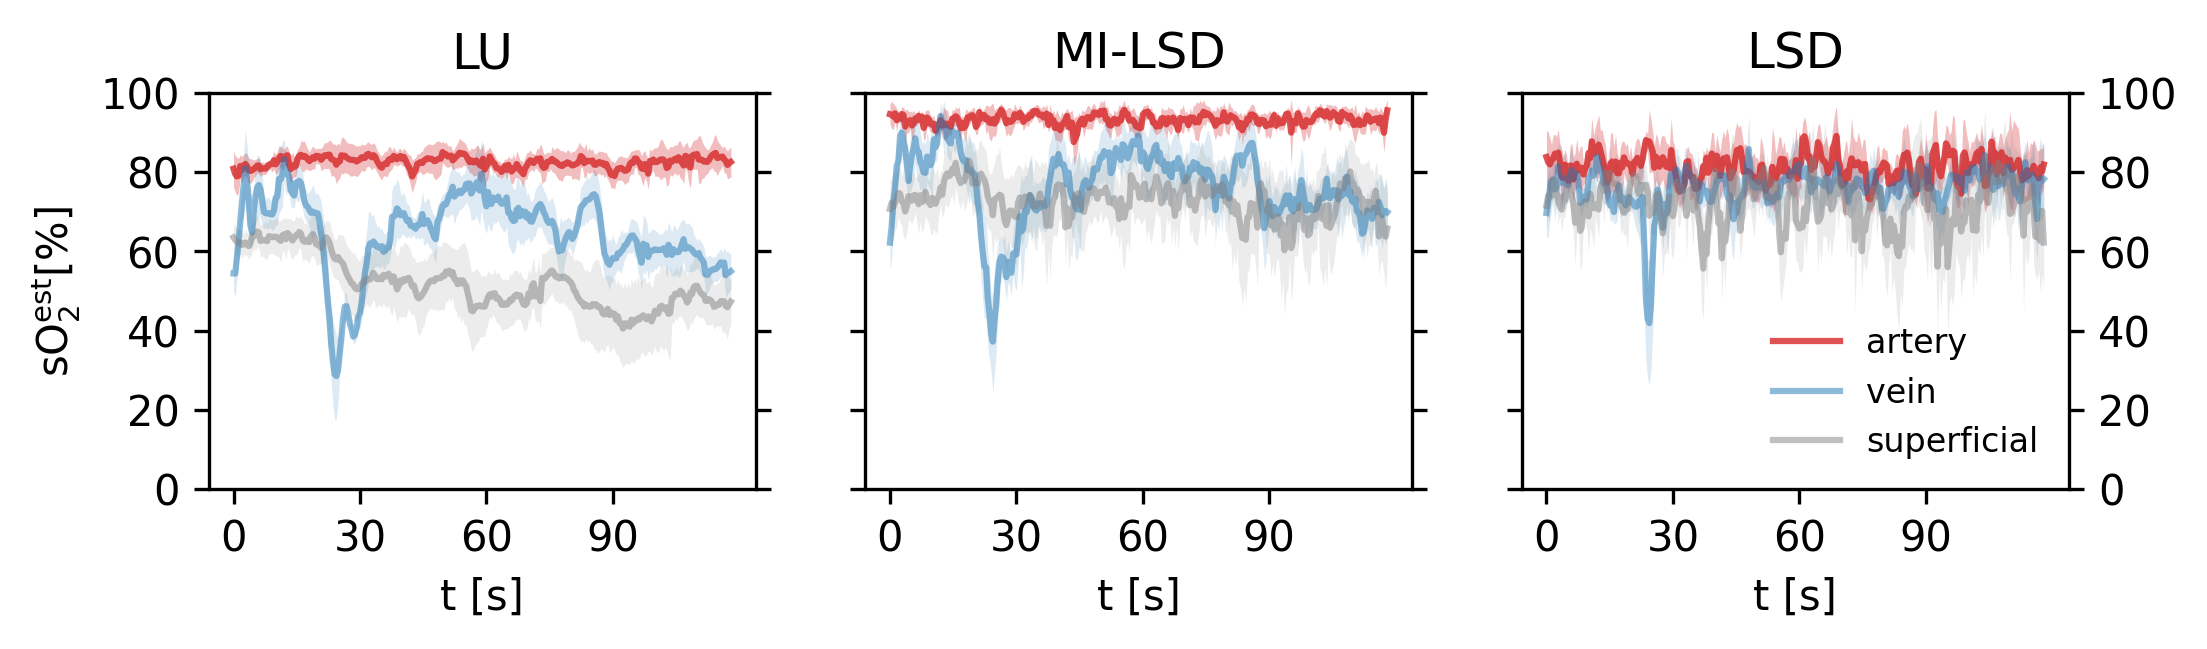

In [10]:
    fig, ax = plt.subplots(1,3, figsize=(8,1.75), dpi=300)
    al = 0.5
    al_a = 0.8
    ax[0].set_title("LU")
    ax[0].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LU_roi_A, axis=(0,1)), 
               label="LU", color="tab:red", alpha=al_a)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_A, axis=(0,1))-np.std(oxy_est_LU_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_A, axis=(0,1))+np.std(oxy_est_LU_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[0].plot(range(oxy_est_LU_m.shape[2]), np.mean(oxy_est_LU_roi_V, axis=(0,1)), 
               label="LU", color="tab:blue", alpha=al)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_V, axis=(0,1))-np.std(oxy_est_LU_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_V, axis=(0,1))+np.std(oxy_est_LU_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[0].plot(range(oxy_est_LU_m.shape[2]), np.mean(oxy_est_LU_roi_SV, axis=(0,1)), 
               label="LU", color="grey", alpha=al)
    ax[0].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LU_roi_SV, axis=(0,1))-np.std(oxy_est_LU_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_LU_roi_SV, axis=(0,1))+np.std(oxy_est_LU_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)

    ax[0].set_ylim(0,1)
    ax[0].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[0].set_xticklabels(np.arange(0, 119, step=30))
    ax[0].set_xlabel("t [s]")
    ax[0].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[0].set_yticklabels(np.arange(0, 101, step=20))
    ax[0].set_ylabel("sO$_{2}^\mathrm{ est} [\%]$")


    ax[1].set_title("MI-LSD")
    ax[1].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1)), 
               label="MI-LSD", color="tab:red", alpha=al_a)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_A, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[1].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1)), 
               label="MI-LSD", color="tab:blue", alpha=al)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_V, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[1].plot(range(oxy_est_MI_LSD_m.shape[2]), 
               np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1)), 
               label="MI-LSD", color="grey", alpha=al)
    ax[1].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1))-np.std(oxy_est_MI_LSD_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_MI_LSD_roi_SV, axis=(0,1))+np.std(oxy_est_MI_LSD_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)

    ax[1].set_ylim(0,1)
    ax[1].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[1].set_xticklabels(np.arange(0, 119, step=30))
    ax[1].set_xlabel("t [s]")
    ax[1].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[1].set_yticklabels(np.arange(0, 101, step=20))
    #ax[1].set_ylabel("sO$_{2}^\mathrm{est} [\%]$")


    ax[2].set_title("LSD")
    ax[2].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_A, axis=(0,1)), 
               label="artery", color="tab:red", alpha=al_a)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_A, axis=(0,1))-np.std(oxy_est_LSD_roi_A, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_A, axis=(0,1))+np.std(oxy_est_LSD_roi_A, axis=(0,1)),
                       alpha=0.3, edgecolor="tab:red", facecolor="tab:red",
                       linewidth=0, antialiased=True)

    ax[2].plot(range(oxy_est_LU_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_V, axis=(0,1)), 
               label="vein", color="tab:blue", alpha=al)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_V, axis=(0,1))-np.std(oxy_est_LSD_roi_V, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_V, axis=(0,1))+np.std(oxy_est_LSD_roi_V, axis=(0,1)),
                       alpha=0.15, edgecolor="tab:blue", facecolor="tab:blue",
                       linewidth=0, antialiased=True)

    ax[2].plot(range(oxy_est_LSD_m.shape[2]), 
               np.mean(oxy_est_LSD_roi_SV, axis=(0,1)), 
               label="superficial", color="grey", alpha=al)
    ax[2].fill_between(range(oxy_est_LU_m.shape[2]), 
                       np.mean(oxy_est_LSD_roi_SV, axis=(0,1))-np.std(oxy_est_LSD_roi_SV, axis=(0,1)), 
                       np.mean(oxy_est_LSD_roi_SV, axis=(0,1))+np.std(oxy_est_LSD_roi_SV, axis=(0,1)),
                       alpha=0.15, edgecolor="grey", facecolor="grey",
                       linewidth=0, antialiased=True)
    ax[2].legend(frameon=False, loc=4, prop={'size': 8})
    ax[2].set_ylim(0,1)
    ax[2].set_xticks(np.arange(0, 295.1, step=30/0.4))
    ax[2].set_xticklabels(np.arange(0, 119, step=30))
    ax[2].set_xlabel("t [s]")
    ax[2].set_yticks(np.arange(0, 1.001, step=0.2))
    ax[2].set_yticklabels(np.arange(0, 101, step=20))
    
    #ax[2].set_ylabel("sO$_{2}^\mathrm{est} [\%]$")

    ax[0].tick_params(right=True)
    ax[1].tick_params(right=True, labelright=False, labelleft=False)
    ax[2].tick_params(right=True, labelright=True, labelleft=False)
    
    #plt.tight_layout()
    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/estimates_auto"+TAG+".png")
    plt.savefig(fname=IN_VIVO_ACQ_FOLDER+"/estimates_auto"+TAG+".svg")
    plt.show()

In [ ]:
print("first 12s")
print("radial artery: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_A[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_A[...,:30])*100,0))))

print("radial artery: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_A[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_A[...,:30])*100,0))))

print("radial artery: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_A[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_A[...,:30])*100,0))))

print("radial vein: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_V[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_V[...,:30])*100,0))))

print("radial vein: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_V[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_V[...,:30])*100,0))))

print("radial vein: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_V[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_V[...,:30])*100,0))))

print("superficial vessel: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_SV[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_SV[...,:30])*100,0))))

print("superficial vessel: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_SV[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_SV[...,:30])*100,0))))

print("superficial vessel: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_SV[...,:30])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_SV[...,:30])*100,0))))


print("last 12s")
print("radial artery: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_A[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_A[...,250:280])*100,0))))

print("radial artery: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_A[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_A[...,250:280])*100,0))))

print("radial artery: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_A[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_A[...,250:280])*100,0))))

print("radial vein: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_V[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_V[...,250:280])*100,0))))

print("radial vein: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_V[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_V[...,250:280])*100,0))))

print("radial vein: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_V[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_V[...,250:280])*100,0))))

print("superficial vessel: LU "
      + str(int(np.round(np.mean(oxy_est_LU_roi_SV[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LU_roi_SV[...,250:280])*100,0))))

print("superficial vessel: MI-LSD "
      + str(int(np.round(np.mean(oxy_est_MI_LSD_roi_SV[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_MI_LSD_roi_SV[...,250:280])*100,0))))

print("superficial vessel: LSD "
      + str(int(np.round(np.mean(oxy_est_LSD_roi_SV[...,250:280])*100,0)))
      + "±" 
      + str(int(np.round(np.std(oxy_est_LSD_roi_SV[...,250:280])*100,0))))


/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/LU_sO2.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 frames
/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/LSD_sO2.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 frames
/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/MI_LSD_sO2.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 frames
/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/LU_THb.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 frames
/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/LU_sO2_m.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 

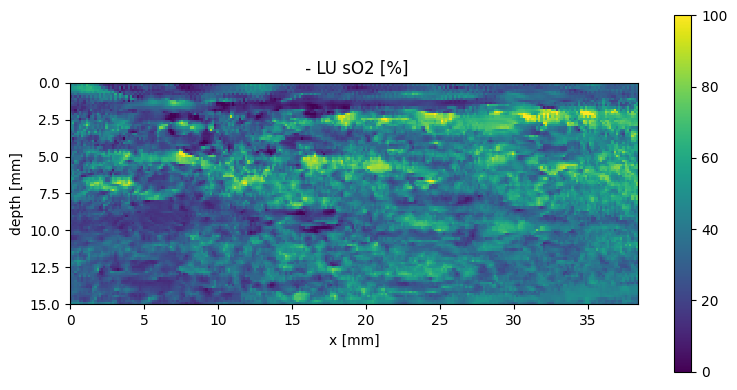

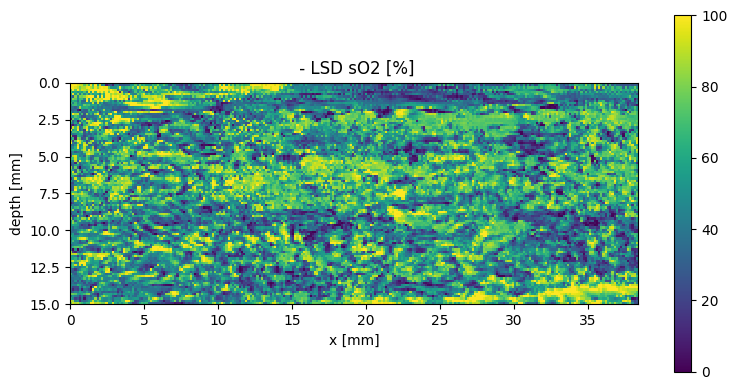

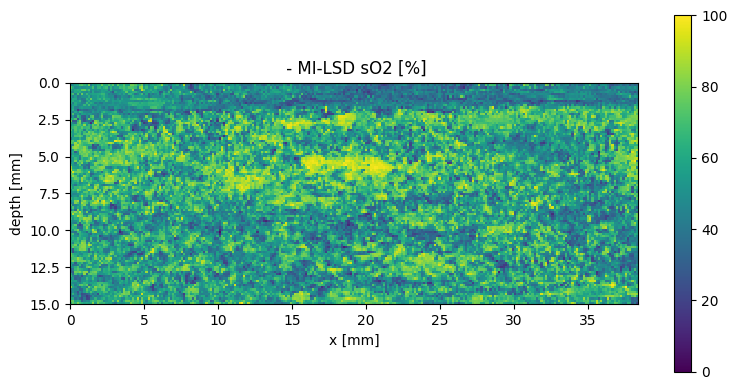

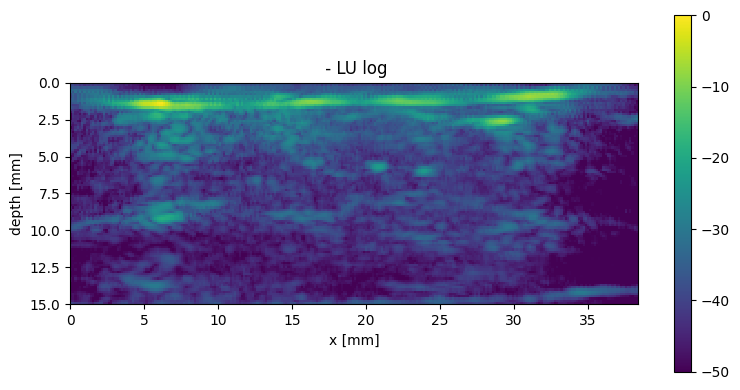

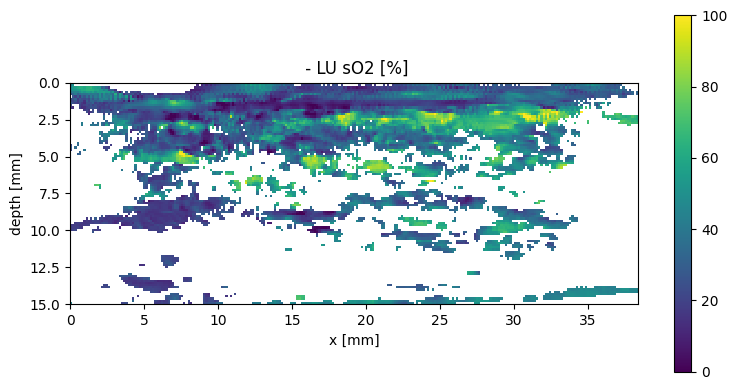

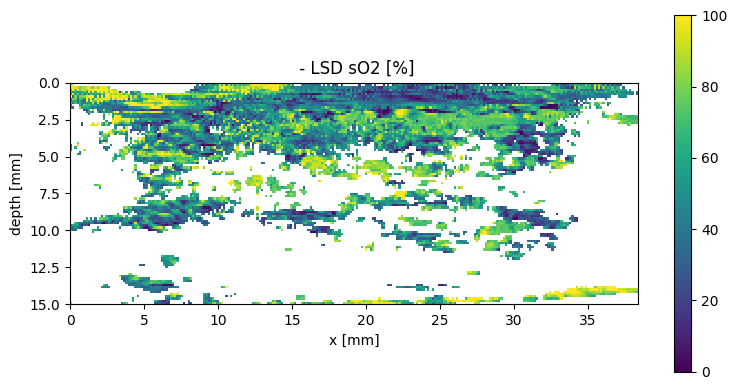

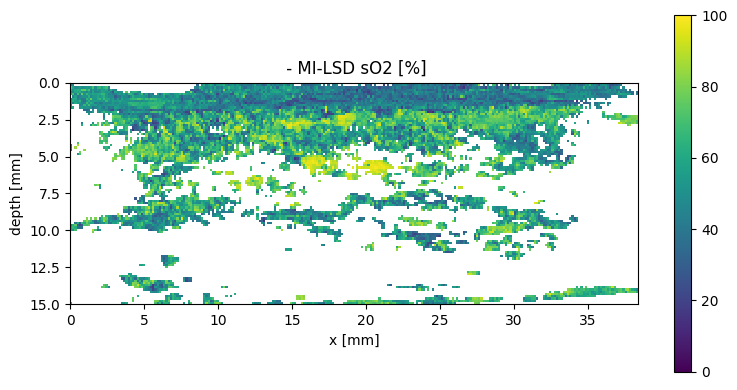

In [11]:
# render videos

qpas.create_vid(inputData=oxy_est_LU*100.0, filename=IN_VIVO_ACQ_FOLDER+"/LU_sO2", 
           titel=" - LU sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

qpas.create_vid(inputData=oxy_est_LSD*100.0, filename=IN_VIVO_ACQ_FOLDER+"/LSD_sO2", 
           titel=" - LSD sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

qpas.create_vid(inputData=oxy_est_MI_LSD*100.0, filename=IN_VIVO_ACQ_FOLDER+"/MI_LSD_sO2", 
           titel=" - MI-LSD sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

qpas.create_vid(inputData=total_hemoglobin_LU, filename=IN_VIVO_ACQ_FOLDER+"/LU_THb", 
           titel=" - LU log" , vmin=-50, vmax=0, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'Log', aspect = 1)

qpas.create_vid(inputData=oxy_est_LU_m*100.0, filename=IN_VIVO_ACQ_FOLDER+"/LU_sO2_m", 
           titel=" - LU sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

qpas.create_vid(inputData=oxy_est_LSD_m*100.0, filename=IN_VIVO_ACQ_FOLDER+"/LSD_sO2_m", 
           titel=" - LSD sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

qpas.create_vid(inputData=oxy_est_MI_LSD_m*100.0, filename=IN_VIVO_ACQ_FOLDER+"/MI_LSD_sO2_m", 
           titel=" - MI-LSD sO2 [%]" , vmin=0, vmax=100, fps = 24, resolution=0.15, cmap = cm.viridis, 
           normalize_frame = 'False', aspect = 1)

In [12]:
def create_tracking_vid(inputData, filename, titel, resolution, vmin, vmax,
                        fps = 20, cmap = cm.viridis, 
                        normalize_frame = 'True', aspect = 1):
    """Rendering a video of US or PA inputData.
    """
    d = 2
    
    def update_img(n):
        global a
        global v
        global sv
        if(normalize_frame == 'One'):
            _cur_data_norm = (inputData[:,:,n]/np.nanmax(inputData[:,:,n]))
        if(normalize_frame == 'Log'):
            _cur_data_norm = 20 * np.log10(inputData[:,:,n]/np.nanmax(inputData[:,:,:]))
        if(normalize_frame == 'True'):
            _cur_data_norm = inputData[:,:,n]/np.nanmax(inputData)
        if(normalize_frame == 'False'):
            _cur_data_norm = inputData[:,:,n]

        foo_A = _cur_data_norm[a[0]-d:a[0]+d+1,
                               a[1]-d:a[1]+d+1]
        foo_V = _cur_data_norm[v[0]-d:v[0]+d+1,
                               v[1]-d:v[1]+d+1]
        foo_SV = _cur_data_norm[sv[0]-d:sv[0]+d+1,
                                sv[1]-d:sv[1]+d+1]

        a = np.unravel_index(foo_A.argmax(), 
                             foo_A.shape) + np.asarray(a) - np.asarray([d,d])
        v = np.unravel_index(foo_V.argmax(), 
                             foo_V.shape) + np.asarray(v) - np.asarray([d,d])
        sv = np.unravel_index(foo_SV.argmax(), 
                              foo_SV.shape) + np.asarray(sv) - np.asarray([d,d])

        _cur_data_norm[a[0]-d:a[0]+d+1, a[1]] = 0
        _cur_data_norm[a[0], a[1]-d:a[1]+d+1] = 0
        _cur_data_norm[v[0]-d:v[0]+d+1, v[1]] = 0
        _cur_data_norm[v[0], v[1]-d:v[1]+d+1] = 0
        _cur_data_norm[sv[0]-d:sv[0]+d+1, sv[1]] = 0
        _cur_data_norm[sv[0], sv[1]-d:sv[1]+d+1] = 0
        
        im.set_data(_cur_data_norm[:,:].T)
        if n%100==0:
            print("vid progress: "+str(n)+"/"+str(inputData.shape[2])+" frames")
        return im
    
    global a
    global v
    global sv
    
    plt.style.use('default')
    dpi = 300
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if(normalize_frame == 'One'):
        _cur_data_norm = (inputData[:,:,0]/np.nanmax(inputData[:,:,0]))
        vmin = 0
        vmax = 1
    if(normalize_frame == 'Log'):
        _cur_data_norm = 20 * np.log10(inputData[:,:,0]/np.nanmax(inputData))
        vmin = vmin
        vmax = 0
    if(normalize_frame == 'True'):
        _cur_data_norm = inputData[:,:,0]/np.nanmax(inputData)
        vmin = vmin
        vmax = vmax
    if(normalize_frame == 'False'):
        _cur_data_norm = inputData[:,:,0]
        vmin = vmin
        vmax = vmax
    extent = [0, inputData.shape[0]*resolution, inputData.shape[1]*resolution, 0]

    im = ax.imshow(_cur_data_norm[:,:].T, 
                   cmap = cmap, 
                   vmin = vmin, vmax = vmax,
                   interpolation = 'nearest', 
                   extent = extent)
    fig.set_size_inches([8,4])
    fig.colorbar(im, ax = ax)
    plt.title(titel)
    plt.xlabel("x [mm]")
    plt.ylabel("depth [mm]")
    plt.tight_layout()

    ani = animation.FuncAnimation(fig, update_img, 
                                  inputData[0,0,:].size, 
                                  interval = 20)
    writer = animation.FFMpegWriter(fps = fps, bitrate = None)
    
    #FFMpegWriter 	Pipe-based ffmpeg writer.
    testpath = filename + '.mp4'
    print(testpath)
    ani.save(testpath, writer = writer, dpi = dpi)
    return ani

In [13]:
pa_i = np.mean(pa_corr_for_lsd[:,:,:,:], axis=2)

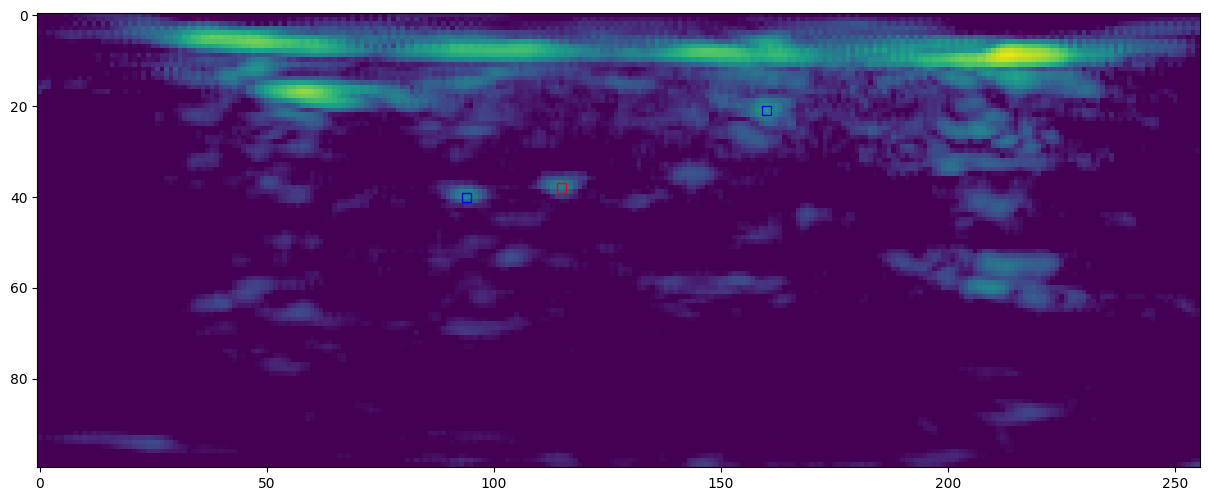

/media/thomas/Extreme SSD/in_vivo_data/baselines/acquisition_20210816T162159/tracking_roi.mp4
vid progress: 0/296 frames
vid progress: 0/296 frames
vid progress: 100/296 frames
vid progress: 200/296 frames


<Figure size 640x480 with 0 Axes>

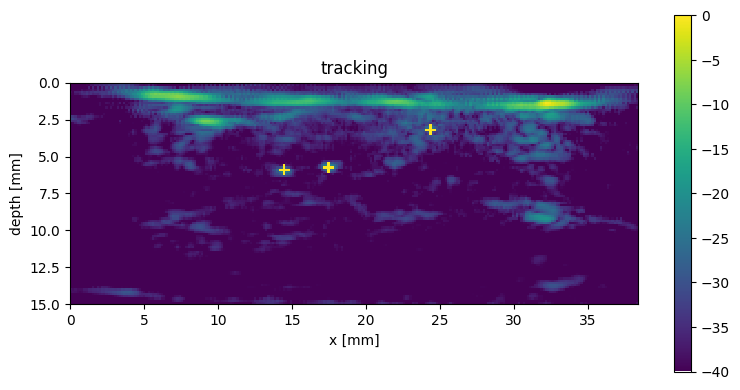

In [14]:
foo_A = pa_i[xa1:xa2,
             ya1:ya2,0]
foo_V = pa_i[xv1:xv2,
             yv1:yv2,0]
foo_SV = pa_i[xsv1:xsv2,
              ysv1:ysv2,0]

a = np.unravel_index(foo_A.argmax(), foo_A.shape) + np.asarray([xa1,ya1])
v = np.unravel_index(foo_V.argmax(), foo_V.shape) + np.asarray([xv1,yv1])
sv = np.unravel_index(foo_SV.argmax(), foo_SV.shape) + np.asarray([xsv1,ysv1])

fig1, ax1 = plt.subplots(1,1,figsize=(15,7))

ax1.imshow(20*np.log10(pa_i[:,:,0]/np.nanmax(pa_i[:,:,:])).T, vmin=-40, vmax=0)

rect = patches.Rectangle((a[0]-1, a[1]-1), 2, 2, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((v[0]-1, v[1]-1), 2, 2, linewidth=1, edgecolor='b', facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((sv[0]-1, sv[1]-1), 2, 2, linewidth=1, edgecolor='b', facecolor='none')
ax1.add_patch(rect)
plt.show()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

create_tracking_vid(inputData=pa_i[...,:], filename=IN_VIVO_ACQ_FOLDER+"/tracking_roi", 
                    titel="tracking" , vmin=-40, vmax=0, fps = 12.5, resolution=0.15, cmap = cm.viridis, 
                    normalize_frame = 'Log', aspect = 1)